## Домашнее задание. Компьютерное зрение.

### Задача: Обучаем нейросеть на датасете MNIST
1. Загрузить датасет MNIST (изображение рукописных цифр)
2. Построить с помощью библиотеки Torch сверточную нейросеть.
  *)сверточная нейросеть представляет из себя один ResNet блок c пуллингом после первого сверточного слоя.
3. Обучить сеть.
4. Сравнить значения функции потерь и метрик качества на train и test.
5. Написать краткий вывод с идеями по улучшению моделии процесса обучения.Результат:
- ноутбук с кодом обучения
- обученная модель
Оценки:
8 баллов за обучение сверточной нейросети.
+2 балла если нейросеть представляет собой ResNetблок.
Дедлайн:28октября


## Импорты

In [2]:
import torch  # PyTorch
import torch.nn as nn   # слои нейронных сетей
import torch.optim as optim   # оптимизаторы
import torchvision    # для компьютерного зрения
import torchvision.transforms as transforms
import torch.nn.functional as F  # для подключения функций активации
from torchsummary import summary    # сводная информация о нейронной сети

import matplotlib.pyplot as plt   # графики
from tqdm import tqdm   # для отслеживания информации в цикле
from sklearn.metrics import confusion_matrix  # confusion matrix (матрица ошибок). для определения метрик качества
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score    # метрики из sklearn


### Версия Torch, константы, вспомогательные функции

In [3]:
# версия torch
print(f'Версия torch. {torch.__version__=}')

Версия torch. torch.__version__='2.5.0+cu121'


In [4]:
# размер batch
batch_size = 64

# Количество эпох
num_epochs = 10

# Скорость обучения
learning_rate = 1

In [5]:
# определение device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 'mps' for Mac
device

device(type='cuda')

In [6]:
# Функция вычисления метрик
def get_metrics(model, y_pred, y_test) -> dict:
  return({
      'model': model.__str__(),
      'accuracy_score' : round(accuracy_score(y_pred, y_test), 3),
      'recall_score' : round(recall_score(y_pred, y_test, average='weighted'), 3),
      'precision_score' : round(precision_score(y_pred, y_test, average='weighted'), 3)
  })

## Модели

### Linear Model

In [180]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(28*28, 100)
        self.activation = nn.Sigmoid()
        self.fc_2 = nn.Linear(100, 10)

    def forward(self, x: torch.Tensor):  # размерность тензора: Batch * Channel * H * W -> Batch * (HxW)
        # преобразуем в вектор. -1 - работаем с любым размером batch (размер определяется автоматически)
        x = x.view((-1, 28*28))
        x = self.fc_1(x)
        x = self.activation(x)
        x = self.fc_2(x)
        # output = LinaerModel(input)
        return x

### CNN Model

In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 1-й свёрточный слой. in_channels=1, т.к. изображение ч/б; out_channels=16, т.е. на выходе 16 карт активации (16 признаков)
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)   # Применяет двумерную свертку к входному сигналу, состоящему из нескольких входных плоскостей
        # уменьшим размер свёрточного фильтра kernel_size=3 и padding=1
        # self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.activation = nn.Tanh()         # Функция активации - гиперболический тангенс
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))    # pooling. Уменьшает размер входных данных по их пространственным измерениям (высоте и ширине), беря максимальное значение по входному окну (размер которого определяется pool_size) для каждого канала входных данных. Окно смещается на шаги по каждому измерению.
        # 2-й свёрточный слой.
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # Двумерная свёртка
        # 3-й свёрточный слой.
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # Двумерная свёртка
        # линейный слой
        self.fc = nn.Linear(7*7*32, 10)

    # в свёрточных сетях полезно прописывать размерности по каждому слою
    def forward(self, x: torch.Tensor): # размерность тензора: Batch * C * H * W: 64 * 1 * 28 * 28, где C - количество каналов
        x = self.conv_1(x)              # размерность тензора: Batch * C * H * W: 64 * 16 * 28 * 28
        x = self.activation(x)          # размерность тензора: Batch * C * H * W: 64 * 16 * 28 * 28
        x = self.pool(x)                # размерность тензора: Batch * C * H * W: 64 * 16 * 14 * 14
        x = self.conv_2(x)              # размерность тензора: Batch * C * H * W: 64 * 32 * 14 * 14
        x = self.activation(x)          # размерность тензора: Batch * C * H * W: 64 * 32 * 14 * 14
        x = self.pool(x)                # размерность тензора: Batch * C * H * W: 64 * 32 * 7 * 7
        x = self.conv_3(x)              # размерность тензора: Batch * C * H * W: 64 * 32 * 7 * 7
        x = self.activation(x)          # размерность тензора: Batch * C * H * W: 64 * 32 * 7 * 7
        x = x.view((-1, 7*7*32))        # размерность тензора: Batch * C * H * W: 64 * (7*7*32)
        x = self.fc(x)                  # размерность тензора: Batch * C * H * W: 64 * 10
        return x

### ResNet Model

In [8]:
class ResNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 1-й свёрточный слой.
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.activation = nn.Tanh()
        self.pool = nn.AvgPool2d(kernel_size=(2, 2))
        # 2-й свёрточный слой.
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 3-й свёрточный слой.
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        # линейный слой
        self.fc = nn.Linear(7*7*32, 10)

        # слой для skip connection (для создания тензора необходимой размерности)
        # self.skip_conn = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=1, padding=0, stride=4)
        # self.skip_conn = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=1, padding=0, stride=2)
        self.skip_conn = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, padding=0, stride=2)

    def forward(self, x: torch.Tensor): # размерность тензора x_input: Batch * C * H * W: 64 * 1 * 28 * 28

        x = self.conv_1(x)              # размерность тензора: Batch * C * H * W: 64 * 16 * 28 * 28
        x = self.activation(x)          # размерность тензора: Batch * C * H * W: 64 * 16 * 28 * 28
        x = self.pool(x)                # размерность тензора: Batch * C * H * W: 64 * 16 * 14 * 14

        # преобразуем тензор к необходимому размеру (размер тензора третьего свёрточного слоя)
        x_input = self.skip_conn(x)     # размерность тензора x_input: Batch * 64 * 32 * 7 * 7

        x = self.conv_2(x)              # размерность тензора: Batch * C * H * W: 64 * 32 * 14 * 14
        x = self.activation(x)          # размерность тензора: Batch * C * H * W: 64 * 32 * 14 * 14
        x = self.pool(x)                # размерность тензора: Batch * C * H * W: 64 * 32 * 7 * 7
        x = self.conv_3(x)              # размерность тензора: Batch * C * H * W: 64 * 32 * 7 * 7

        # суммируем тензор x (тензор после третьего свёрточного слоя) и x_input (входной тензор после преобразования)
        x = torch.add(x, x_input)

        x = self.activation(x)          # размерность тензора: Batch * C * H * W: 64 * 32 * 7 * 7
        x = x.view((-1, 7*7*32))        # размерность тензора: Batch * C * H * W: 64 * (7*7*32)
        x = self.fc(x)                  # размерность тензора: Batch * C * H * W: 64 * 10
        return x

## Загрузка датасета MINST (изображение рукописных цифр)

In [9]:
# Data Normalization
# Набор трансформаций
# Загрузка и нормализация данных. transforms.Compose формирует конвейер преобразования, через который проходят ВСЕ изображения при входе в модель для обучения.
# В torchvision.transforms.Normalize на вход передаются среднее и отклонение для каждого канала. Среднее: torch.mean(), отклонение: torch.std().
transform = transforms.Compose([transforms.ToTensor(),                # преобразуем в тензор
                                transforms.Normalize([0.0], [1.])]    # нормализуем (среднее, дисперсия)
                               )
transform

Compose(
    ToTensor()
    Normalize(mean=[0.0], std=[1.0])
)

In [10]:
# MNIST dataset
# импортируем из библиотеки torchvision
# Тренировочный датасет
train_dataset = torchvision.datasets.MNIST(root='data',           # куда положить датасет
                                           train=True,            # тренировочная часть датасета
                                           transform=transform,   # необходимые трансформации с данными перед загрузкой в датасет
                                           download=True)         # скачиваем

# Тестовый датасет
test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False,
                                          transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [11]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.0], std=[1.0])
           )

In [12]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.0], std=[1.0])
           )

In [13]:
# Data loader. Загрузчик. Класс, который работает с датасетом и помогает грузить по batch.

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,   # выбираем датасет
                                               batch_size=batch_size,   # размер batch
                                               shuffle=True)            # Перемешивать (получить в случайном порядке)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)

In [14]:
train_dataloader

In [15]:
len(train_dataloader)

938

In [16]:
test_dataloader

In [17]:
next(iter(train_dataloader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [18]:
# item (элемент) - tensor, label (метка) - tensor
item, label = next(iter(train_dataloader))

In [19]:
item.shape

torch.Size([64, 1, 28, 28])

In [20]:
label.shape

torch.Size([64])

In [21]:
label

tensor([2, 0, 0, 7, 0, 1, 4, 0, 7, 0, 4, 4, 1, 5, 6, 5, 7, 2, 3, 8, 8, 7, 4, 1,
        4, 6, 7, 7, 7, 2, 6, 8, 4, 7, 3, 2, 9, 6, 8, 9, 3, 5, 2, 6, 9, 1, 8, 7,
        3, 4, 1, 5, 9, 5, 3, 7, 0, 1, 0, 4, 4, 9, 5, 4])

Учитель. label[index].item()=2


Text(0.5, 1.0, 'tensor(2)')

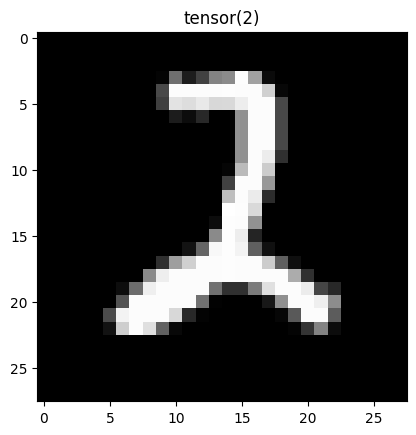

In [22]:
# Посмотрим, что загрузилось
# индекс картинки в batch
index = 0
print(f'Учитель. {label[index].item()=}')
picture = item[index, 0]

# fig, ax = plt.subplots(nrows=1, ncols=2)
plt.imshow(picture, cmap='gray')
plt.title(label[index])

## Обучение сети

### Подготовка

In [23]:
# ПОДГОТОВКА
# Создаём модель
# линейная модель
# model = LinearModel()
# свёрточная модель
# model = CNNModel()
# свёрточная модель (один ResNet блок)
model = ResNetModel()

# оптимизатор
optimizer = torch.optim.SGD(lr=learning_rate, params=model.parameters())
# функция потерь
# BCEWithLogitsLoss() соединяет Sigmoid и BCELoss в одном классе. Работает более стабильно.
loss_function = nn.BCEWithLogitsLoss()
# loss_function = nn.CrossEntropyLoss()

# scheduler изменяет learning_rate в зависимости от расписания. в данной задаче можно работать без него.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000) # cos((1000 / 1000) * pi) * lr -> eta_min

# сводная информация о модели
summary(model.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              Tanh-2           [-1, 16, 28, 28]               0
         AvgPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]             544
            Conv2d-5           [-1, 32, 14, 14]           4,640
              Tanh-6           [-1, 32, 14, 14]               0
         AvgPool2d-7             [-1, 32, 7, 7]               0
            Conv2d-8             [-1, 32, 7, 7]           9,248
              Tanh-9             [-1, 32, 7, 7]               0
           Linear-10                   [-1, 10]          15,690
Total params: 30,538
Trainable params: 30,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.12
Estimated Tot

### Обучение модели

In [24]:
# Обучение модели

# Передаём model на device
model.to(device)

# Перевод модели в режим обучения
model.train()

# список значений функции потерь для train
loss_list_train = []

total_step = len(train_dataloader)

# список учителей (train)
true_labels_list_train = []
# список прогнозов модели (train)
predicted_labels_list_train = []

# для каждой эпохи
for epoch in tqdm(range(1, num_epochs + 1)):
  # для каждой части датасета
    for i, (images, labels) in enumerate(train_dataloader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # расширяем список true_labels_list_train
        true_labels_list_train.extend(labels.cpu().numpy())

        # применяем OneHotEncoding для учителей с одновременным преобразованием к float32. Получаем вектор величиной batch_size длиной num_classes
        labels = F.one_hot(labels, num_classes=10).to(torch.float32)

        # Forward pass (прямой проход). Попадаем в forward.
        outputs = model(images)
        # функция потерь для прохода
        loss = loss_function(outputs, labels)  # criterion

        # для расчёта метрик
        # пропускаем через сигмоиду
        outputs = F.sigmoid(outputs)
        # получаем вектор predict_train
        predicted_labels = torch.argmax(outputs, dim=1)
        # расширяем список predicted_labels_list_train
        predicted_labels_list_train.extend(predicted_labels.cpu().numpy())

        # Backward and optimize
        # обнуляем градиенты у оптимизатора
        optimizer.zero_grad()
        # делаем шаг в обратном направлении (backpropagation), считаем все градиенты
        loss.backward()
        # делаем шаг оптимизатора (обновляем веса)
        optimizer.step()

        loss_list_train.append(loss.detach().cpu().numpy())

        if (i + 1) % 100 == 0:
            print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

    # меняем learning_rate
    scheduler.step()

# После обучения очистить кэш
with torch.no_grad():
    torch.cuda.empty_cache()

print (f'\nFinish:\nEpoch [{epoch}/{num_epochs}], Step [{len(loss_list_train)}/{total_step * num_epochs}], Loss: {loss.item():.4f}')

# метрики качества. считаем при помощи sklearn
train_metrics = get_metrics(model=model, y_pred=predicted_labels_list_train, y_test=true_labels_list_train)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/938], Loss: 0.0762
Epoch [1/10], Step [200/938], Loss: 0.0661
Epoch [1/10], Step [300/938], Loss: 0.0488
Epoch [1/10], Step [400/938], Loss: 0.0455
Epoch [1/10], Step [500/938], Loss: 0.0299
Epoch [1/10], Step [600/938], Loss: 0.0267
Epoch [1/10], Step [700/938], Loss: 0.0295
Epoch [1/10], Step [800/938], Loss: 0.0204
Epoch [1/10], Step [900/938], Loss: 0.0326


 10%|█         | 1/10 [00:18<02:42, 18.09s/it]

Epoch [2/10], Step [100/938], Loss: 0.0253
Epoch [2/10], Step [200/938], Loss: 0.0216
Epoch [2/10], Step [300/938], Loss: 0.0303
Epoch [2/10], Step [400/938], Loss: 0.0204
Epoch [2/10], Step [500/938], Loss: 0.0632
Epoch [2/10], Step [600/938], Loss: 0.0225
Epoch [2/10], Step [700/938], Loss: 0.0303
Epoch [2/10], Step [800/938], Loss: 0.0170
Epoch [2/10], Step [900/938], Loss: 0.0214


 20%|██        | 2/10 [00:33<02:13, 16.69s/it]

Epoch [3/10], Step [100/938], Loss: 0.0266
Epoch [3/10], Step [200/938], Loss: 0.0205
Epoch [3/10], Step [300/938], Loss: 0.0152
Epoch [3/10], Step [400/938], Loss: 0.0188
Epoch [3/10], Step [500/938], Loss: 0.0147
Epoch [3/10], Step [600/938], Loss: 0.0128
Epoch [3/10], Step [700/938], Loss: 0.0113
Epoch [3/10], Step [800/938], Loss: 0.0069
Epoch [3/10], Step [900/938], Loss: 0.0134


 30%|███       | 3/10 [00:49<01:54, 16.30s/it]

Epoch [4/10], Step [100/938], Loss: 0.0333
Epoch [4/10], Step [200/938], Loss: 0.0065
Epoch [4/10], Step [300/938], Loss: 0.0346
Epoch [4/10], Step [400/938], Loss: 0.0123
Epoch [4/10], Step [500/938], Loss: 0.0034
Epoch [4/10], Step [600/938], Loss: 0.0138
Epoch [4/10], Step [700/938], Loss: 0.0081
Epoch [4/10], Step [800/938], Loss: 0.0064
Epoch [4/10], Step [900/938], Loss: 0.0186


 40%|████      | 4/10 [01:06<01:38, 16.41s/it]

Epoch [5/10], Step [100/938], Loss: 0.0087
Epoch [5/10], Step [200/938], Loss: 0.0194
Epoch [5/10], Step [300/938], Loss: 0.0058
Epoch [5/10], Step [400/938], Loss: 0.0107
Epoch [5/10], Step [500/938], Loss: 0.0074
Epoch [5/10], Step [600/938], Loss: 0.0064
Epoch [5/10], Step [700/938], Loss: 0.0163
Epoch [5/10], Step [800/938], Loss: 0.0068
Epoch [5/10], Step [900/938], Loss: 0.0232


 50%|█████     | 5/10 [01:22<01:21, 16.21s/it]

Epoch [6/10], Step [100/938], Loss: 0.0079
Epoch [6/10], Step [200/938], Loss: 0.0173
Epoch [6/10], Step [300/938], Loss: 0.0043
Epoch [6/10], Step [400/938], Loss: 0.0230
Epoch [6/10], Step [500/938], Loss: 0.0237
Epoch [6/10], Step [600/938], Loss: 0.0077
Epoch [6/10], Step [700/938], Loss: 0.0040
Epoch [6/10], Step [800/938], Loss: 0.0220
Epoch [6/10], Step [900/938], Loss: 0.0073


 60%|██████    | 6/10 [01:37<01:04, 16.07s/it]

Epoch [7/10], Step [100/938], Loss: 0.0120
Epoch [7/10], Step [200/938], Loss: 0.0093
Epoch [7/10], Step [300/938], Loss: 0.0111
Epoch [7/10], Step [400/938], Loss: 0.0251
Epoch [7/10], Step [500/938], Loss: 0.0068
Epoch [7/10], Step [600/938], Loss: 0.0105
Epoch [7/10], Step [700/938], Loss: 0.0140
Epoch [7/10], Step [800/938], Loss: 0.0211
Epoch [7/10], Step [900/938], Loss: 0.0033


 70%|███████   | 7/10 [01:53<00:47, 15.95s/it]

Epoch [8/10], Step [100/938], Loss: 0.0047
Epoch [8/10], Step [200/938], Loss: 0.0129
Epoch [8/10], Step [300/938], Loss: 0.0100
Epoch [8/10], Step [400/938], Loss: 0.0103
Epoch [8/10], Step [500/938], Loss: 0.0206
Epoch [8/10], Step [600/938], Loss: 0.0029
Epoch [8/10], Step [700/938], Loss: 0.0033
Epoch [8/10], Step [800/938], Loss: 0.0044
Epoch [8/10], Step [900/938], Loss: 0.0136


 80%|████████  | 8/10 [02:10<00:32, 16.18s/it]

Epoch [9/10], Step [100/938], Loss: 0.0045
Epoch [9/10], Step [200/938], Loss: 0.0072
Epoch [9/10], Step [300/938], Loss: 0.0055
Epoch [9/10], Step [400/938], Loss: 0.0032
Epoch [9/10], Step [500/938], Loss: 0.0086
Epoch [9/10], Step [600/938], Loss: 0.0248
Epoch [9/10], Step [700/938], Loss: 0.0192
Epoch [9/10], Step [800/938], Loss: 0.0156
Epoch [9/10], Step [900/938], Loss: 0.0087


 90%|█████████ | 9/10 [02:26<00:16, 16.13s/it]

Epoch [10/10], Step [100/938], Loss: 0.0016
Epoch [10/10], Step [200/938], Loss: 0.0089
Epoch [10/10], Step [300/938], Loss: 0.0050
Epoch [10/10], Step [400/938], Loss: 0.0100
Epoch [10/10], Step [500/938], Loss: 0.0033
Epoch [10/10], Step [600/938], Loss: 0.0044
Epoch [10/10], Step [700/938], Loss: 0.0020
Epoch [10/10], Step [800/938], Loss: 0.0059
Epoch [10/10], Step [900/938], Loss: 0.0018


100%|██████████| 10/10 [02:42<00:00, 16.22s/it]



Finish:
Epoch [10/10], Step [9380/9380], Loss: 0.0012


### Тестирование модели

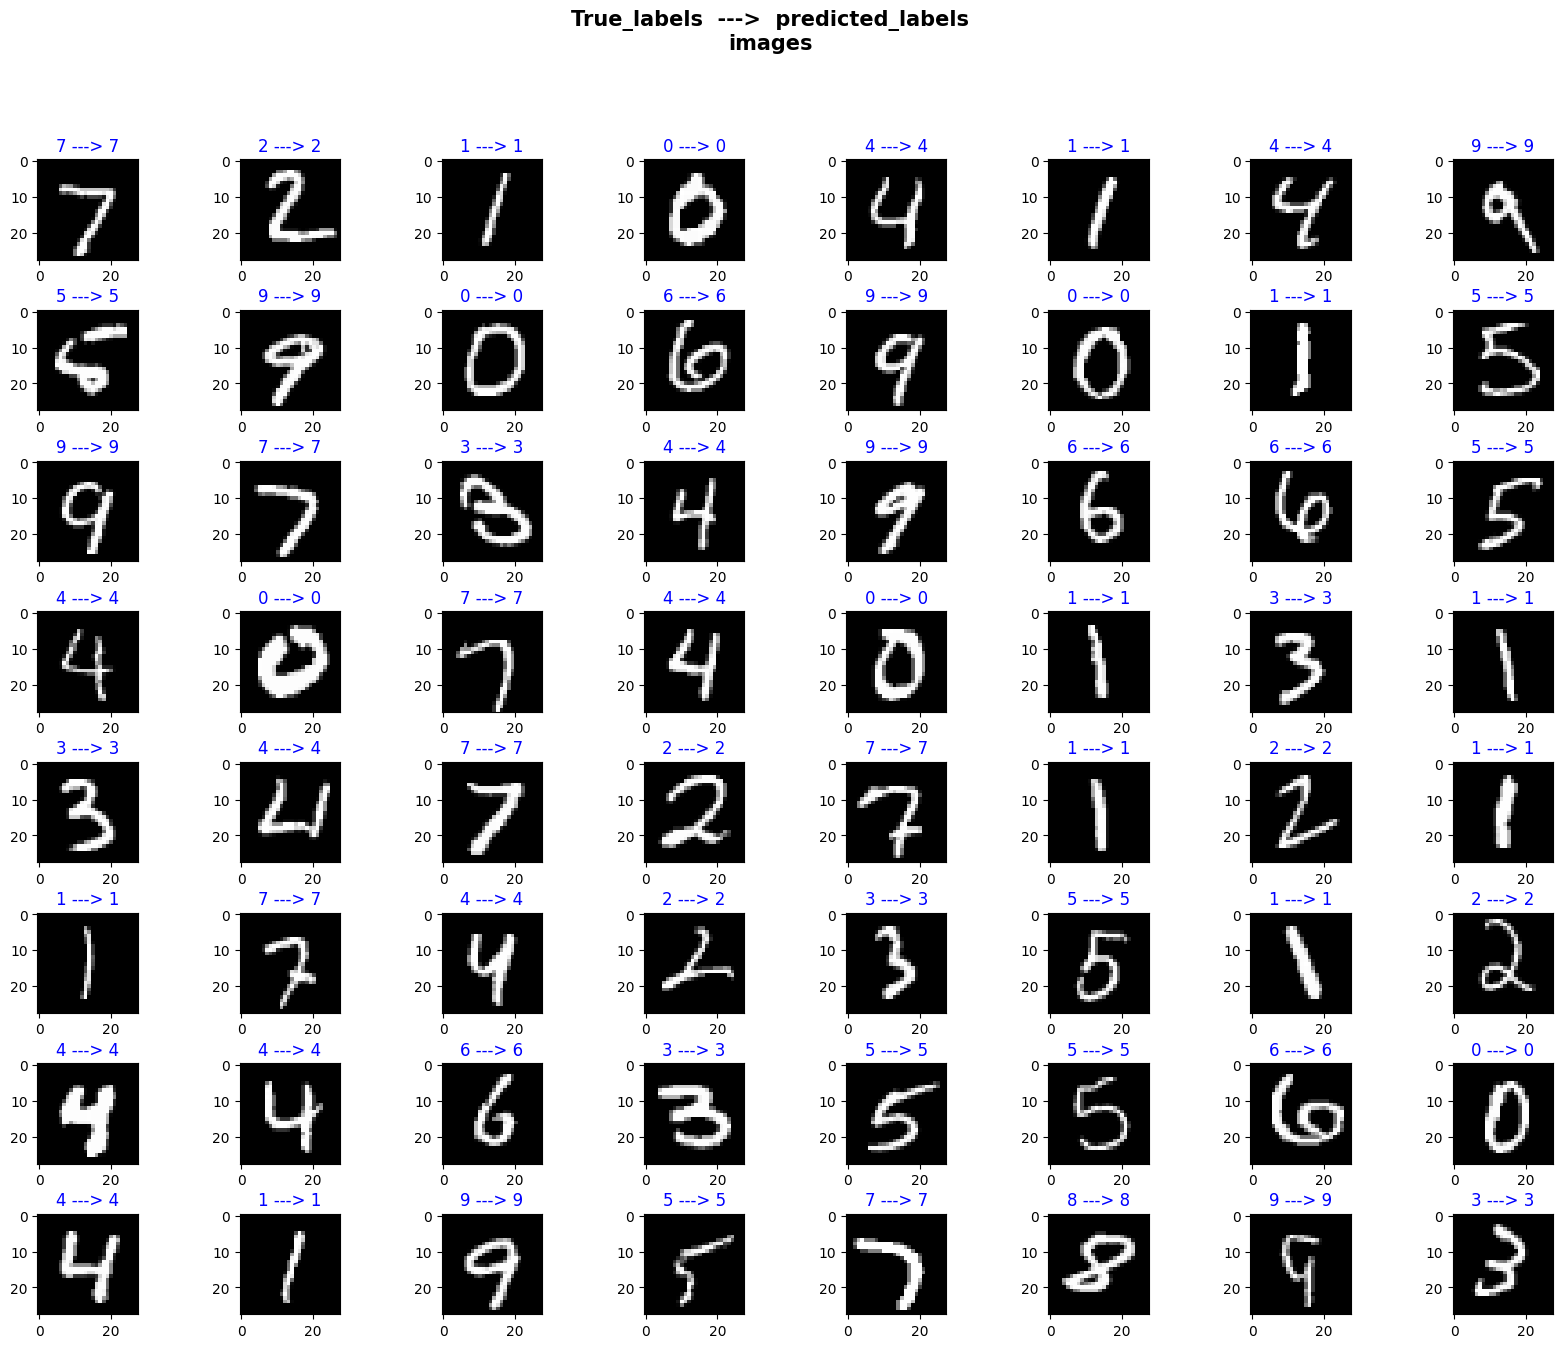

In [25]:
# Тестирование модели

# список учителей
true_labels_list_test = []
# список прогнозов модели
predicted_labels_list_test = []

# список значений функции потерь для test
loss_list_test = []

# Перевод модели в режим вычисления
model.eval()

# отображение картинок, учителей и predict для batch
show_batch = True

# цикл для каждой части (batch) тестового датасета
for images, labels in test_dataloader:

    images = images.to(device)
    labels = labels.to(device)

    # In test phase, we don't need to compute gradients (for memory efficiency)
    # В тестовом режиме нет необходимости вычислять градиенты
    with torch.no_grad():
        # считаем predict
        predict = model(images)

    # расширяем список true_labels_list_test
    true_labels_list_test.extend(labels.cpu().numpy())

    # для графика функции потерь test
    # применяем OneHotEncoding для учителей с одновременным преобразованием к float32. Получаем вектор величиной batch_size длиной num_classes
    labels = F.one_hot(labels, num_classes=10).to(torch.float32)

    # функция потерь для прохода
    loss = loss_function(predict, labels)  # criterion
    # добавляем значение в список
    loss_list_test.append(loss.detach().cpu().numpy())

    # пропускаем через сигмоиду
    predict = F.sigmoid(predict)  # model do not contain nn.Sigmoid
    # argmax - ищет индекс с максимальным значением -> предсказанный label
    predicted_labels = torch.argmax(predict, dim=1)

    predicted_labels_list_test.extend(predicted_labels.cpu().numpy())

    # отрисуем первый batch
    if show_batch:
      # Посмотрим, что и как определилось (на примере последнего batch)
      plt.figure(figsize=[20, 15])
      # растояния между графиками
      plt.subplots_adjust(wspace=0.5, hspace=0.5)
      plt.suptitle('True_labels  --->  predicted_labels\nimages', fontsize=15, fontweight='bold')

      for idx in range(batch_size):
        picture = images[idx][0].cpu()

        plt.subplot(int(batch_size ** 0.5), int(batch_size ** 0.5), idx + 1)
        plt.imshow(picture, cmap='gray')
        plt.title(f'{true_labels_list_test[idx]} ---> {predicted_labels_list_test[idx]}', fontsize=12, color='blue')
      show_batch = False

# метрики качества. считаем при помощи sklearn
test_metrics = get_metrics(model=model, y_pred=predicted_labels_list_test, y_test=true_labels_list_test)

# но можно и напрямую через confusion matrix
cm = confusion_matrix(true_labels_list_test, predicted_labels_list_test)

## Функция потерь и метрики качества:

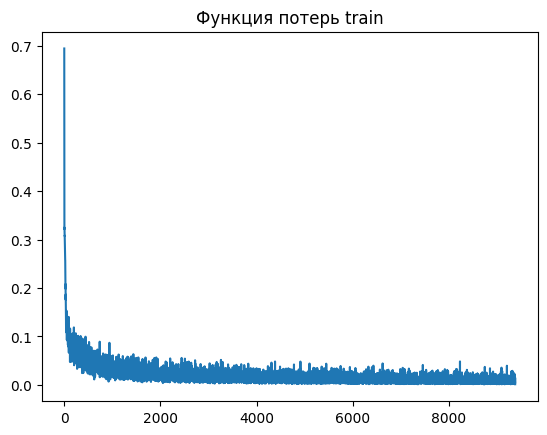

In [26]:
plt.title('Функция потерь train')
plt.plot(loss_list_train)

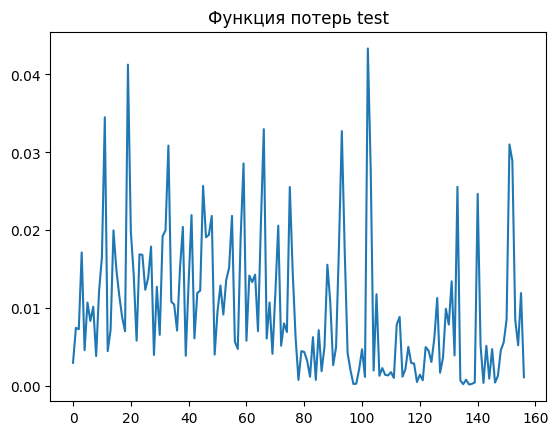

In [27]:
plt.title('Функция потерь test')
plt.plot(loss_list_test)

In [28]:
train_metrics

{'model': 'ResNetModel(\n  (conv_1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n  (activation): Tanh()\n  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)\n  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n  (conv_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n  (fc): Linear(in_features=1568, out_features=10, bias=True)\n  (skip_conn): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))\n)',
 'accuracy_score': 0.975,
 'recall_score': 0.975,
 'precision_score': 0.975}

In [29]:
test_metrics

{'model': 'ResNetModel(\n  (conv_1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n  (activation): Tanh()\n  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)\n  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n  (conv_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n  (fc): Linear(in_features=1568, out_features=10, bias=True)\n  (skip_conn): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))\n)',
 'accuracy_score': 0.986,
 'recall_score': 0.986,
 'precision_score': 0.986}

In [30]:
cm

array([[ 974,    0,    0,    0,    0,    0,    4,    1,    1,    0],
       [   0, 1126,    2,    1,    0,    0,    2,    0,    3,    1],
       [   1,    1, 1024,    0,    0,    0,    0,    3,    3,    0],
       [   0,    0,    2,  999,    0,    4,    0,    1,    0,    4],
       [   1,    0,    2,    0,  946,    0,    4,    0,    1,   28],
       [   0,    0,    0,    5,    0,  884,    1,    0,    0,    2],
       [   4,    2,    1,    1,    1,    2,  946,    0,    1,    0],
       [   0,    3,    7,    4,    0,    0,    0, 1004,    1,    9],
       [   3,    0,    3,    2,    2,    2,    1,    2,  955,    4],
       [   0,    2,    0,    0,    1,    3,    0,    2,    0, 1001]])

In [32]:
cm.diagonal()

array([ 974, 1126, 1024,  999,  946,  884,  946, 1004,  955, 1001])

In [33]:
accuracy_test = cm.diagonal() / cm.sum(axis=1)
# accuracy по классам
accuracy_test

array([0.99387755, 0.99207048, 0.99224806, 0.98910891, 0.96334012,
       0.99103139, 0.9874739 , 0.9766537 , 0.98049281, 0.99207136])

In [34]:
# среднее значение accuracy
accuracy_test.mean()

0.9858368292228936

In [35]:
model.state_dict()

OrderedDict([('conv_1.weight',
              tensor([[[[-3.3308e-01, -4.5696e-01, -2.8598e-01, -9.2037e-03, -1.3116e-01],
                        [-9.8609e-02, -6.1138e-01, -6.2307e-01, -3.1037e-01, -1.7005e-01],
                        [-1.3789e-01, -4.4345e-01, -4.8205e-01, -3.9239e-01, -6.8042e-02],
                        [ 1.1285e-01, -1.3641e-01, -3.2557e-01,  2.2781e-01,  4.0393e-01],
                        [ 3.4622e-02,  2.3348e-01,  4.5357e-01,  4.7957e-01,  6.0458e-01]]],
              
              
                      [[[-3.4376e-01, -9.2458e-02, -8.4066e-02,  1.1511e-01, -2.2130e-01],
                        [-3.3500e-01, -5.4363e-02,  2.0879e-01, -8.1518e-02, -2.4683e-02],
                        [-7.9725e-02,  1.6770e-01,  1.9048e-01,  2.0999e-01, -3.4349e-02],
                        [ 5.7718e-03,  3.0954e-02,  4.2591e-01,  4.0787e-01,  3.5612e-01],
                        [-3.4042e-01,  3.0087e-03,  1.3236e-01,  4.1743e-02,  2.0127e-01]]],
              
          

## Сохранение и загрузка модели

### Сохранение только весов модели

In [36]:
# torch.save(model.state_dict(), 'cnn_model_dict.ckpt')
torch.save(model.state_dict(), 'resnet_model_dict.ckpt')

In [37]:
# создаём модель
# model = LinearModel()
# model = CNNModel()
model = ResNetModel()
# загружаем в неё веса
model.load_state_dict(torch.load('resnet_model_dict.ckpt', weights_only=True))

<All keys matched successfully>

### Сохранение модели вместе с весами

In [38]:
# torch.save(model, 'cnn_model.ckpt')
torch.save(model, 'resnet_model.ckpt')

In [40]:
# загружаем готовую модель (вместе с весами)
# model = torch.load('cnn_model.ckpt')
model = torch.load('resnet_model.ckpt')

<ipython-input-40-747a19e7b15e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('resnet_model.ckpt')


## Выводы и идеи

In [ ]:
# ВЫВОДЫ

# 0. Использование GPU вместо CPU очень сильно ускоряет процесс обучения модели. Правда в Google Colab не всегда получается сменить среду выполнения.
#
# 1. Accuracy_test (kernel_size=5, padding=2) = 0.977, Accuracy_test (kernel_size=3, padding=1) = 0.975.
#    Изменение размера свёрточного фильтра в 1-м свёрточном слое с 5х5 до 3х3 практически не изменило метрику Accuracy.
#    Можно оставить 5х5.
#
# 2. Accuracy_test (num_epochs = 10) = 0.977
#    Accuracy_test (num_epochs = 20) = 0,986
#    Accuracy_test (num_epochs = 5) = 0,986
#    Увеличение количества эпох с 10 до 20 привело к увеличению времени обучения модели и улучшению метрики Accuracy_test.
#    Уменьшение количества эпох с 10 до 5 привело к уменьшению времени обучения модели. Метрики Accuracy_train и Accuracy_test практически сравнялись.
#
# 3. Accuracy_test (Learning_rate = 0.001) = 0.47. Модель не обучилась.
#    Accuracy_test (Learning_rate = 0.01) = 0.89.
#    Accuracy_test (Learning_rate = 0.05) = 0.961.
#    Accuracy_test (Learning_rate = 0.1) = 0.977
#    Accuracy_test (Learning_rate = 0.5) = 0.989.
#    Accuracy_test (Learning_rate = 1.0) = 0.992.
# 4. Для ускорения времени обучения модели можно уменьшить num_epochs до 5. Судя по графику функции потерь, выход на плато происходит в районе 5000-го шага.
#    Дополнительно можно написать метод, который будет считать Accuracy_test во время обучения модели и останавливать процесс обучения при достижении значения Accuracy_test определённого необходимого уровня (например, 0.98).
#
# 5. ResNet
# ResNet — это сокращенное название для Residual Network (дословно  — «остаточная сеть»).
# ResNet (Residual Network) – модель, использующая идею residual learning.
# В рамках этой идеи к выходу каждого слоя прибавляется его вход, таким образом слой выучивает не полноценное новое преобразование входа, а добавочное (остаточное – residual) преобразование.
# Попытался реализовать ResNet сеть в классе class ResNetModel(nn.Module). Вроде обучается. Модель сохранена в файле resnet_model.ckpt.

# В ноутбуке сохранен лучший (как мне показалось) подбор параметров для обучения и тестирования модели CNNModel, при котором метрики качества максимальные.